In [65]:
import pandas as pd 
import json
import numpy as np

In [66]:
#Lecture des données
tunisian_stock_market = 'Tunisian-Stock-Market.json'
with open(tunisian_stock_market, 'r') as json_file:
    
    json_data = json.load(json_file)
TunisianStockMarket = pd.DataFrame(json_data)

In [67]:
#Choix d'une seule action(BNA dans notre cas)
TunisianStockMarket['Date'] = pd.to_datetime(TunisianStockMarket['Date'])
bna_data = TunisianStockMarket[TunisianStockMarket['Stock_name'] == 'STAR']

In [68]:
#Filtrage des colonnes non utile
columnsToExclude = ['Code_isin','Stock_name']
TunisianStockMarketFiltred = bna_data.drop(columns=columnsToExclude)
filtered_data = TunisianStockMarketFiltred[TunisianStockMarketFiltred['Date'].dt.year.isin([2020, 2021])]
print(TunisianStockMarketFiltred)

             Date  Adj_Close  Adj_low  Adj_High        Volume
50     2021-11-04    122.000  122.000   122.000  6.344000e+03
129    2021-11-03    124.000    0.000     0.000  0.000000e+00
208    2021-11-02    124.000    0.000     0.000  0.000000e+00
287    2021-11-01    124.000  124.000   124.000  1.165600e+04
366    2021-10-29    120.000  120.000   120.000  5.832000e+04
...           ...        ...      ...       ...           ...
198633 2011-01-07    153.081  149.478   153.976  5.905699e+04
198689 2011-01-06    152.406  152.406   154.651  5.635900e+03
198745 2011-01-05    155.546  151.040   155.569  1.076413e+06
198801 2011-01-04    151.040  146.801   151.110  2.081262e+05
198857 2011-01-03    145.230  143.150   147.570  5.697502e+04

[2689 rows x 5 columns]


In [69]:
#Function to make date format to datetime
import datetime
def str_to_datetime(s):
    split = s.split('-')
    year , month , day = int(split[0]) , int(split[1]) , int(split[2])
    return datetime.datetime(year=year , month=month , day=day)

In [70]:
#TunisianStockMarketFiltred['Date'] = TunisianStockMarketFiltred['Date'].apply(str_to_datetime)
#TunisianStockMarketFiltred['Date']

In [71]:
TunisianStockMarketFiltred.index = TunisianStockMarketFiltred.pop('Date')
TunisianStockMarketFiltred

,Adj_Close,Adj_low,Adj_High,Volume
Date,,,,
2021-11-04,122.000,122.000,122.000,6.344000e+03
2021-11-03,124.000,0.000,0.000,0.000000e+00
2021-11-02,124.000,0.000,0.000,0.000000e+00
2021-11-01,124.000,124.000,124.000,1.165600e+04
2021-10-29,120.000,120.000,120.000,5.832000e+04
...,...,...,...,...
2011-01-07,153.081,149.478,153.976,5.905699e+04
2011-01-06,152.406,152.406,154.651,5.635900e+03
2011-01-05,155.546,151.040,155.569,1.076413e+06


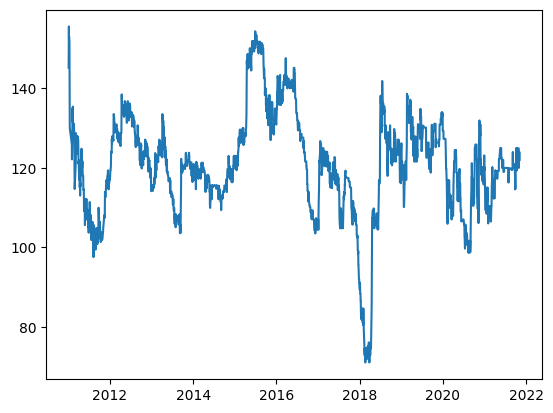

In [72]:
import matplotlib.pyplot as plt 

plt.plot(TunisianStockMarketFiltred.index , TunisianStockMarketFiltred['Adj_Close'])

In [73]:
#Create windowed data every 3 days
def window_data(data, n=3):
    windowed_data = pd.DataFrame()
    for i in range(n, 0, -1):
        windowed_data[f'Target-{i}'] = data['Adj_Close'].shift(i)
    windowed_data['Target'] = data['Adj_Close']
    return windowed_data.dropna()


windowed_data = window_data(TunisianStockMarketFiltred, n = 3)
windowed_data.sort_index(inplace=True, ascending=True)
windowed_data

,Target-3,Target-2,Target-1,Target
Date,,,,
2011-01-03,152.406,155.546,151.040,145.230
2011-01-04,153.081,152.406,155.546,151.040
2011-01-05,151.778,153.081,152.406,155.546
2011-01-06,144.948,151.778,153.081,152.406
2011-01-07,136.124,144.948,151.778,153.081
...,...,...,...,...
2021-10-26,120.000,124.900,124.900,124.900
2021-10-27,124.000,120.000,124.900,124.900
2021-10-28,124.000,124.000,120.000,124.900


In [74]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = windowed_dataframe.index.values

  middle_matrix = df_as_np[:, 0:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_data)

dates.shape, X.shape, y.shape


((2686,), (2686, 3, 1), (2686,))

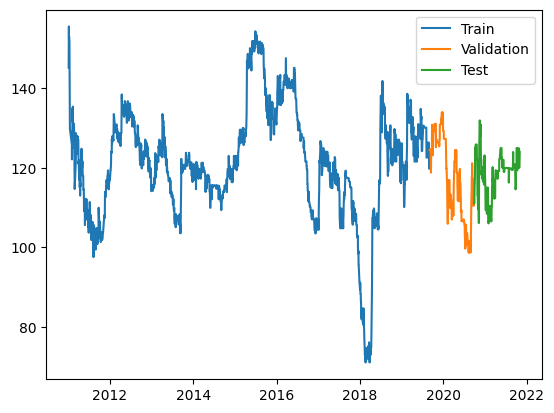

In [75]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [76]:
from tensorflow.keras.models import Sequential #Sequential model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers 
import distutils



model = Sequential([layers.Input((3,1)),
                    layers.LSTM(64),
                    layers.Dense(32 , activation='relu'),
                    layers.Dense(32 , activation='relu'),
                    layers.Dense(1)])

model.compile(loss='MSE' ,
               optimizer=Adam(learning_rate=0.001),
              metrics = ['mean_absolute_error'])

model.fit(X_train, y_train , validation_data = (X_val , y_val) , epochs=100)


Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 14534.2500 - mean_absolute_error: 119.6122 - val_loss: 9375.9980 - val_mean_absolute_error: 96.4373
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6650.9922 - mean_absolute_error: 76.2840 - val_loss: 154.9542 - val_mean_absolute_error: 10.0327
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 187.2856 - mean_absolute_error: 10.0128 - val_loss: 26.6404 - val_mean_absolute_error: 4.5252
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.6478 - mean_absolute_error: 3.8751 - val_loss: 7.0726 - val_mean_absolute_error: 2.0921
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.2028 - mean_absolute_error: 2.1127 - val_loss: 6.8678 - val_mean_absolute_error: 2.0527
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1583 - mean_absolute_error: 1.8491 - val_loss: 6.2190 - val_mean_absolute_error: 2.0310
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1674 - mean_absolute_er

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


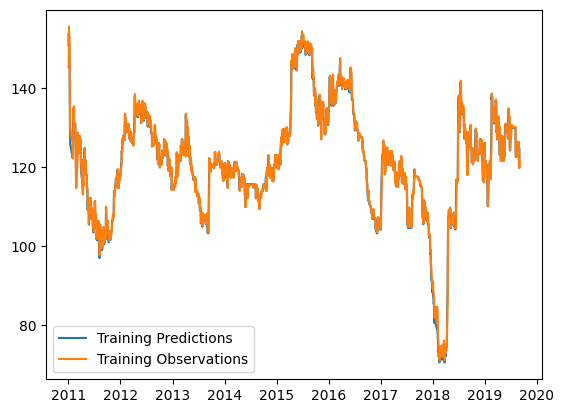

In [77]:
train_prediction = model.predict(X_train).flatten()

plt.plot(dates_train , train_prediction)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions' , 'Training Observations'])

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


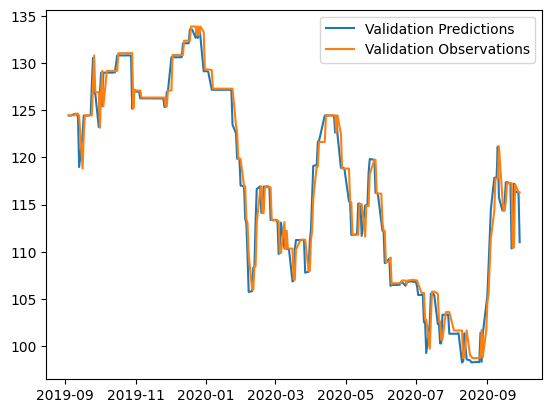

In [78]:
val_prediction = model.predict(X_val).flatten()

plt.plot(dates_val , val_prediction)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions' , 'Validation Observations'])

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


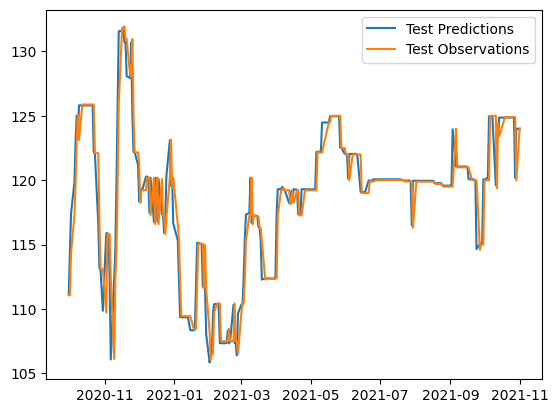

In [79]:
test_prediction = model.predict(X_test).flatten()

plt.plot(dates_test , test_prediction)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions' , 'Test Observations'])

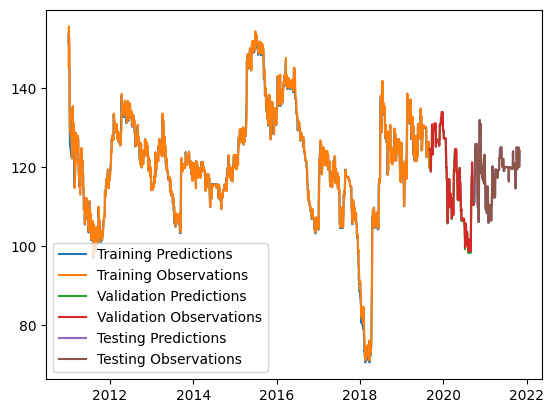

In [80]:
plt.plot(dates_train, train_prediction)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_prediction)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_prediction)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [84]:
from copy import deepcopy
recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

last_window = deepcopy(X_train[-1])
for target_date in recursive_dates:
    next_prediction = model.predict(np.array([last_window]), verbose=False).flatten()
    print(target_date, last_window[:, 0], next_prediction)
    recursive_predictions.append(next_prediction)
    
    last_window[0] = last_window[1]
    last_window[1] = last_window[2]
    last_window[2] = next_prediction

2020-09-30T00:00:00.000000000 [124.475 124.475 124.475] [124.452126]
2020-10-01T00:00:00.000000000 [124.475    124.475    124.452126] [124.430305]
2020-10-02T00:00:00.000000000 [124.475    124.452126 124.430305] [124.40905]
2020-10-05T00:00:00.000000000 [124.452126 124.430305 124.40905 ] [124.388435]
2020-10-06T00:00:00.000000000 [124.430305 124.40905  124.388435] [124.36844]
2020-10-07T00:00:00.000000000 [124.40905  124.388435 124.36844 ] [124.34904]
2020-10-08T00:00:00.000000000 [124.388435 124.36844  124.34904 ] [124.3302]
2020-10-09T00:00:00.000000000 [124.36844 124.34904 124.3302 ] [124.31192]
2020-10-12T00:00:00.000000000 [124.34904 124.3302  124.31192] [124.294174]
2020-10-13T00:00:00.000000000 [124.3302   124.31192  124.294174] [124.27695]
2020-10-14T00:00:00.000000000 [124.31192  124.294174 124.27695 ] [124.260216]
2020-10-16T00:00:00.000000000 [124.294174 124.27695  124.260216] [124.24397]
2020-10-19T00:00:00.000000000 [124.27695  124.260216 124.24397 ] [124.22821]
2020-10-20

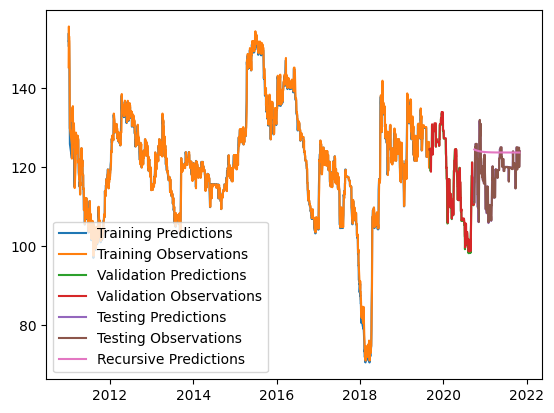

In [86]:
plt.plot(dates_train, train_prediction)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_prediction)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_prediction)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])